## Correcting for "glint"

Some CHEOPS data sets are affected by _glint_ - artefacts caused by scattered light that is not removed by the data reduction pipeline. These are thought to be caused by internal reflections within the telescope structure, e.g., moonlight reflected from the secondary mirror vanes.

To account for glint we can construct a smooth function as a function of the spacecraft roll angle. This can be constructed from the data outside the eclipse or by fitting the residuals from an initial fit to the data. In this notebook we fit the out-of-eclipse data.

For the specific case of an internal reflection due to moonlight, use `datatset.add_glint(moon=True)` to account for the motion of the Moon during the exposure (not done here). Use `dataset.planet_check()` to determine if the moon or other solar system body is close to the target during the observation.

This notebook demonstrates the correction for glint within `pycheops`  by injecting a simulated glint artefact into a simulated dataset. 

In [1]:
%pylab inline
from pycheops import Dataset
from uncertainties import ufloat
from pycheops.constants import R_SunN, c

Populating the interactive namespace from numpy and matplotlib


### Load  dataset
Using the same CHEOPSim simulated dataset as `dataset_fit_eclipse_from_simulation`.

In [2]:
#dataset=Dataset.from_test_data('DP-080', target='EBLM J0113+31')
dataset = Dataset('CH_PR900048_TG001701_V0000', target='EBLM J0113+31')
_  = dataset.get_lightcurve(aperture='OPTIMAL')

time, flux, flux_err = dataset.clip_outliers(verbose=True)

Found archive tgzfile /Users/pflm/pycheops/data/CH_PR900048_TG001701_V0000.tgz
 PI name     : CHEOPSim
 OBS ID      : 7798
 Target      : EBLM J0113+31
 Coordinates : 01:13:51.33 +31:49:10.1
 Spec. type  : G0
 V magnitude : 10.06 +- 0.00
Light curve data loaded from  /Users/pflm/pycheops/data/CH_PR900048_TG001701_V0000-OPTIMAL.fits
Time stored relative to BJD = 2459128
Aperture radius used = 30 arcsec
Light curve corrected for flux from background stars
Mean counts = 9897665.1
Median counts = 10091105.2
RMS counts = 4375.7 [434 ppm]
Median standard error = 3261.6 [323 ppm]
Mean contamination = 19223.4 ppm

Rejected 5 points more than 5.0 x MAD = 1309 ppm from the median


In [3]:
dataset.planet_check()

BJD = 2459128.6953873313
Body     R.A.         Declination  Sep(deg)
-------------------------------------------
Moon     03:53:04.31  +18:17:55.8      27.0
Mars     01:31:14.12  +05:49:20.6      26.5
Jupiter  19:18:09.25  -22:39:39.2      90.5
Saturn   19:48:23.46  -21:25:31.5      89.0
Uranus   02:28:38.29  +14:10:28.1      24.1
Neptune  23:19:53.22  -05:31:44.3      45.5


### Least-squares fit

 

In [4]:
BJD_0 = 2456023.26988
P = 14.2769001
E = round((dataset.bjd_ref-BJD_0)/P)
T_0 = ufloat(BJD_0 + P*E - dataset.bjd_ref,0.0002)
D = 0.02300
W = 0.01890391
b = 0.299
f_c = 0.08707092 
f_s = -0.54974417 
a_c = 25.808*R_SunN/c/86400  # Light travel time across the orbit in days

result = dataset.lmfit_eclipse(T_0=T_0, P=P, D=D, W=W, b=b, L=(0.0001,0.1),
                               f_c=f_c, f_s=f_s, a_c= a_c) 
print(dataset.lmfit_report())

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 984
    # variables        = 3
    chi-square         = 1407.34450
    reduced chi-square = 1.43460194
    Akaike info crit   = 358.108636
    Bayesian info crit = 372.783514
    RMS residual       = 386.8 ppm
[[Variables]]
    T_0:  -6.64282638 +/- 2.3899e-04 (0.00%) (init = -6.642798)
    P:     14.2769 (fixed)
    D:     0.023 (fixed)
    W:     0.01890391 (fixed)
    b:     0.299 (fixed)
    L:     3.4202e-04 +/- 2.9819e-05 (8.72%) (init = 0.05005)
    f_c:   0.08707092 (fixed)
    f_s:  -0.5497442 (fixed)
    c:     0.98090578 +/- 1.4411e-05 (0.00%) (init = 1)
    a_c:   0.0006931734 (fixed)
    k:     0.15165751 +/- 0.00000000 (0.00%) == 'sqrt(D)'
    aR:    18.7270014 +/- 0.00000000 (0.00%) == 'sqrt((1+k)**2-b**2)/W/pi'
    sini:  0.99987253 +/- 0.00000000 (0.00%) == 'sqrt(1 - (b/aR)**2)'
    e:     0.30980000 +/- 0.00000000 (0.00%) == 'f_c**2 + f_s**2'
[[Correlations]] (unre

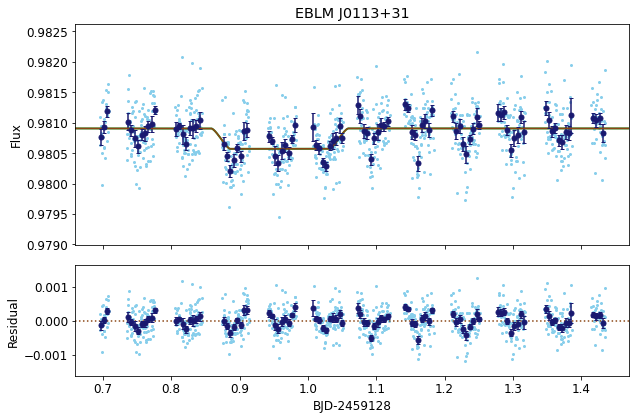

In [5]:
fig = dataset.plot_lmfit(title=dataset.target,figsize=(9,6),fontsize=12,binwidth=0.005)


### Injection of a simulated glint artefact

Glint artefacts tend to show a peak with a dip either side caused by the scattered light perturbing the background flux estimate. Approximate this with a sinc function.

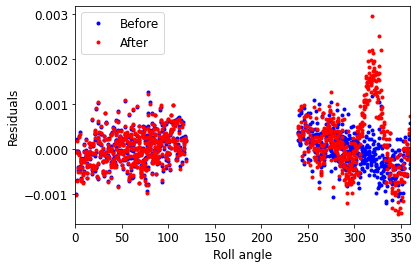

In [6]:
A_glint = 180 ## Amplitude of glint artefact in ppm
angle = np.array(dataset.lc['roll_angle'])
flux = np.array(dataset.lc['flux'])
fit = dataset.lmfit.bestfit
res = flux - fit
plt.plot(angle,res,'b.',label='Before')

phi = (angle-320)*np.pi/180
gfunc = A_glint*1e-6*sin(10*phi)/phi
flux = flux + gfunc
res = flux - fit
plt.plot(angle,res,'r.',label='After')
plt.xlabel('Roll angle')
plt.ylabel('Residuals')
plt.legend()
plt.xlim(0,360)
dataset.lc['flux'] = flux

### Fit to out-of-eclipse data


#### First create a mask file to exclude the eclipse from the fit
Mask position estimated by-eye from the plot of the fit to the eclipse above.

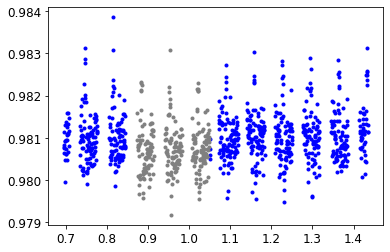

In [7]:
mask = (time > 0.85) & (time < 1.05)
plot(time[~mask],flux[~mask],'o',c='blue',ms=3)
plot(time[mask],flux[mask],'o',c='gray',ms=3)

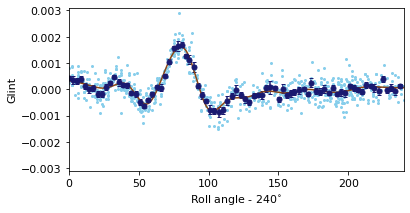

In [8]:
glint = dataset.add_glint(16, binwidth=3, fit_flux=True, mask=mask)

In [9]:
result = dataset.lmfit_eclipse(T_0=T_0, P=P, D=D, W=W, b=b, L=(0.0001,0.1),
                               f_c=f_c, f_s=f_s, a_c= a_c, 
                               dfdsinphi=(-1,1), dfdcosphi=(-1,1), glint_scale=(0,2)) 
print(dataset.lmfit_report())


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 984
    # variables        = 6
    chi-square         = 1143.18541
    reduced chi-square = 1.16890123
    Akaike info crit   = 159.548796
    Bayesian info crit = 188.898552
    RMS residual       = 348.6 ppm
[[Variables]]
    T_0:         -6.64280410 +/- 2.1588e-04 (0.00%) (init = -6.642798)
    P:            14.2769 (fixed)
    D:            0.023 (fixed)
    W:            0.01890391 (fixed)
    b:            0.299 (fixed)
    L:            3.0182e-04 +/- 2.7125e-05 (8.99%) (init = 0.05005)
    f_c:          0.08707092 (fixed)
    f_s:         -0.5497442 (fixed)
    c:            0.98098538 +/- 1.6319e-05 (0.00%) (init = 1)
    a_c:          0.0006931734 (fixed)
    dfdsinphi:    4.3301e-06 +/- 1.4516e-05 (335.23%) (init = 0)
    dfdcosphi:   -1.5545e-05 +/- 2.6222e-05 (168.69%) (init = 0)
    glint_scale:  0.99425444 +/- 0.02467869 (2.48%) (init = 1)
    k:            0.15165751

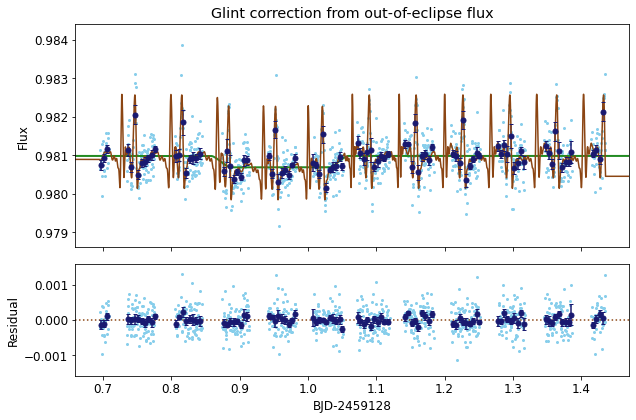

In [10]:
fig = dataset.plot_lmfit(title='Glint correction from out-of-eclipse flux',
                         figsize=(9,6),fontsize=12,binwidth=0.005)

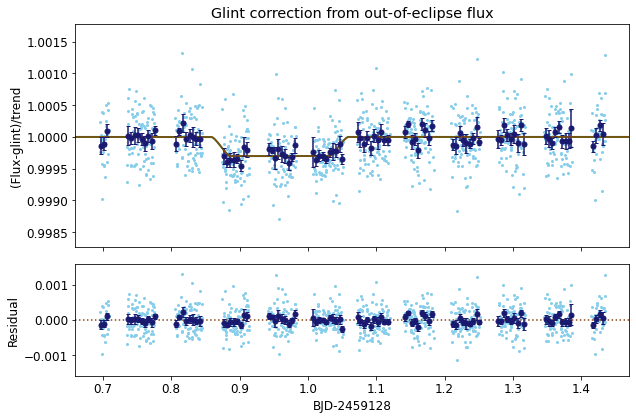

In [11]:
fig = dataset.plot_lmfit(title='Glint correction from out-of-eclipse flux',
                         figsize=(9,6),fontsize=12,binwidth=0.005,detrend=True)


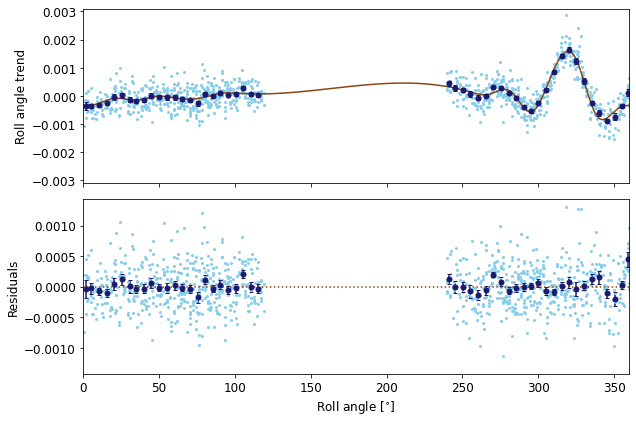

In [12]:
fig = dataset.rollangle_plot(figsize=(9,6),fontsize=12,binwidth=5)

In [13]:
result = dataset.lmfit_eclipse(T_0=T_0, P=P, D=D, W=W, b=b, L=(0.0001,0.1),
                               f_c=f_c, f_s=f_s, a_c= a_c, 
                               dfdsinphi=(-1,1), dfdcosphi=(-1,1), glint_scale=(0,2)) 
print(dataset.lmfit_report())


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 984
    # variables        = 6
    chi-square         = 1143.18541
    reduced chi-square = 1.16890123
    Akaike info crit   = 159.548796
    Bayesian info crit = 188.898552
    RMS residual       = 348.6 ppm
[[Variables]]
    T_0:         -6.64280410 +/- 2.1588e-04 (0.00%) (init = -6.642798)
    P:            14.2769 (fixed)
    D:            0.023 (fixed)
    W:            0.01890391 (fixed)
    b:            0.299 (fixed)
    L:            3.0182e-04 +/- 2.7125e-05 (8.99%) (init = 0.05005)
    f_c:          0.08707092 (fixed)
    f_s:         -0.5497442 (fixed)
    c:            0.98098538 +/- 1.6319e-05 (0.00%) (init = 1)
    a_c:          0.0006931734 (fixed)
    dfdsinphi:    4.3301e-06 +/- 1.4516e-05 (335.23%) (init = 0)
    dfdcosphi:   -1.5545e-05 +/- 2.6222e-05 (168.69%) (init = 0)
    glint_scale:  0.99425444 +/- 0.02467869 (2.48%) (init = 1)
    k:            0.15165751

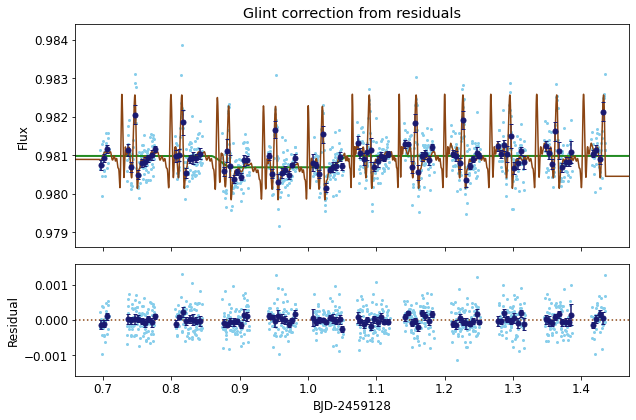

In [14]:
fig = dataset.plot_lmfit(title='Glint correction from residuals',
                         figsize=(9,6),fontsize=12,binwidth=0.005)

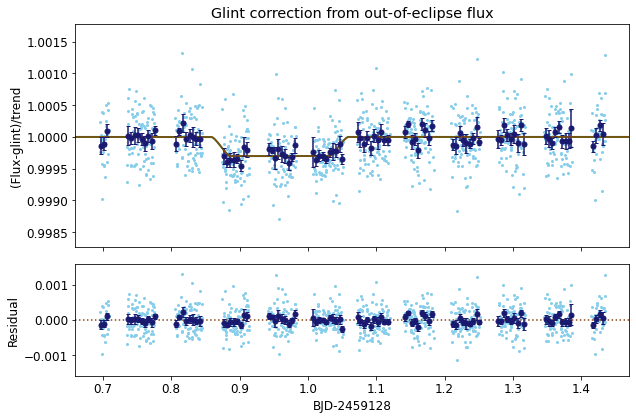

In [15]:
fig = dataset.plot_lmfit(title='Glint correction from out-of-eclipse flux',
                         figsize=(9,6),fontsize=12,binwidth=0.005,detrend=True)


### Sampling the posterior
Sampling the posterior probability distribution using the affine-invariant sampler [emcee](https://emcee.readthedocs.io/en/stable/). 

The $\pm$1-sigma limits on parameters from the prior are indicated in the corner plot using dashed lines.

This return value from emcee_transit is an instance of an [EnsembleSampler](https://emcee.readthedocs.io/en/latest/user/sampler/) object.

In [16]:
sampler = dataset.emcee_sampler()
print(dataset.emcee_report(min_correl=0.5))

Running burn-in ..


100%|██████████| 256/256 [01:44<00:00,  2.44it/s]

Running sampler ..



100%|██████████| 128/128 [00:54<00:00,  2.33it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 8192
    # data points      = 983
    # variables        = 7
    chi-square         = 1143.53626
    reduced chi-square = 1.17165600
    Akaike info crit   = -12856.5166
    Bayesian info crit = -12822.2823
    RMS residual       = 348.7 ppm
[[Variables]]
    T_0:         -6.64282762 +/- 2.0985e-04 (0.00%) (init = -6.642798)
    P:            14.2769 (fixed)
    D:            0.023 (fixed)
    W:            0.01890391 (fixed)
    b:            0.299 (fixed)
    L:            2.9813e-04 +/- 2.5990e-05 (8.72%) (init = 0.05005)
    f_c:          0.08707092 (fixed)
    f_s:         -0.5497442 (fixed)
    c:            0.98098598 +/- 1.6800e-05 (0.00%) (init = 1)
    a_c:          0.0006931734 (fixed)
    dfdsinphi:    5.2197e-06 +/- 1.2402e-05 (237.60%) (init = 0)
    dfdcosphi:   -1.1867e-05 +/- 2.5169e-05 (212.10%) (init = 0)
    glint_scale:  0.99220960 +/- 0.02432717 (2.45%) (init = 1)
    k:            0.151657

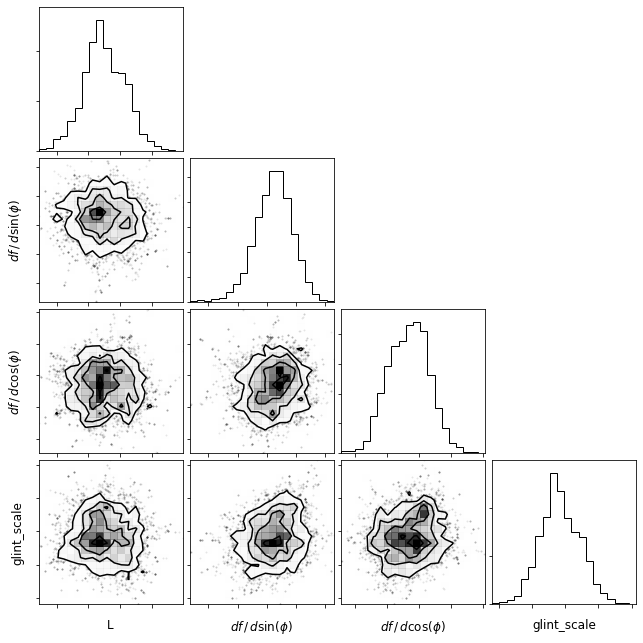

In [17]:
cornerplot = dataset.corner_plot(['L','dfdsinphi','dfdcosphi','glint_scale'])

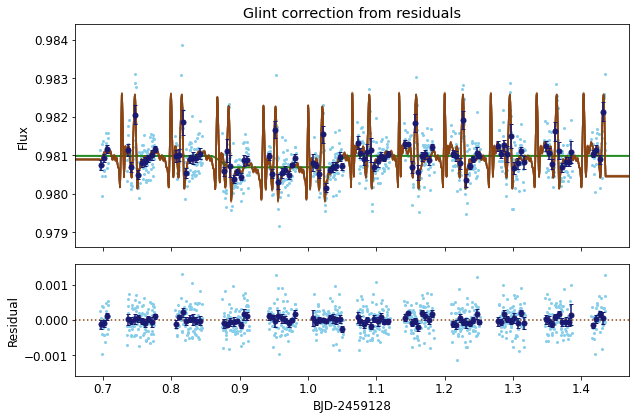

In [18]:
fig = dataset.plot_emcee(title='Glint correction from residuals',
                         figsize=(9,6),fontsize=12, binwidth=0.005)

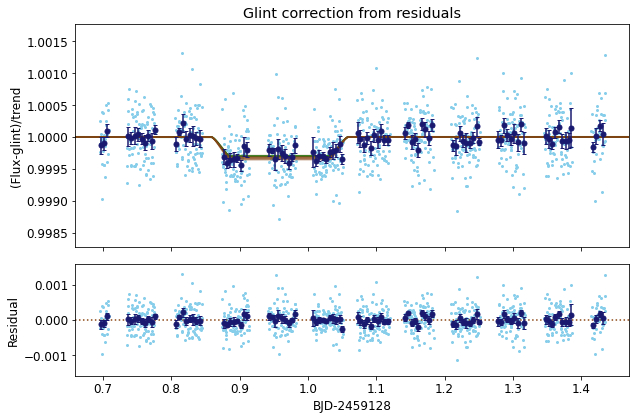

In [19]:
fig = dataset.plot_emcee(title='Glint correction from residuals', detrend=True,
                         figsize=(9,6),fontsize=12, binwidth=0.005)

### Add correlated noise

Now use "add_shoterm=True" so that correlated noise is modelled using the SHOTerm kernel from [celerite](https://celerite.readthedocs.io/en/stable/).

Broad priors on log_sigma, log_omega0 and log_S0 from a previous run of this sampler without priors are used here to remove long tails in the distrubtions with very few samples  that mess up the plots.

In [20]:
sampler = dataset.emcee_sampler(add_shoterm=True,  
                                log_sigma=(-11,-7), log_omega0=(3.5,7.5), log_S0=(-30,-20))
print(dataset.emcee_report())

Running burn-in ..


100%|██████████| 256/256 [02:00<00:00,  2.12it/s]

Running sampler ..



100%|██████████| 128/128 [00:57<00:00,  2.24it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 8192
    # data points      = 983
    # variables        = 9
    chi-square         = 1143.71717
    reduced chi-square = 1.17424760
    Akaike info crit   = -12852.0203
    Bayesian info crit = -12808.0049
    RMS residual       = 348.7 ppm
[[Variables]]
    T_0:         -6.64279755 +/- 2.2806e-04 (0.00%) (init = -6.642798)
    P:            14.2769 (fixed)
    D:            0.023 (fixed)
    W:            0.01890391 (fixed)
    b:            0.299 (fixed)
    L:            3.0320e-04 +/- 2.7010e-05 (8.91%) (init = 0.05005)
    f_c:          0.08707092 (fixed)
    f_s:         -0.5497442 (fixed)
    c:            0.98098977 +/- 1.7730e-05 (0.00%) (init = 1)
    a_c:          0.0006931734 (fixed)
    dfdsinphi:    6.1013e-06 +/- 1.4012e-05 (229.65%) (init = 0)
    dfdcosphi:   -2.2407e-05 +/- 2.5608e-05 (114.29%) (init = 0)
    glint_scale:  0.99643584 +/- 0.02539593 (2.55%) (init = 1)
    k:            0.151657

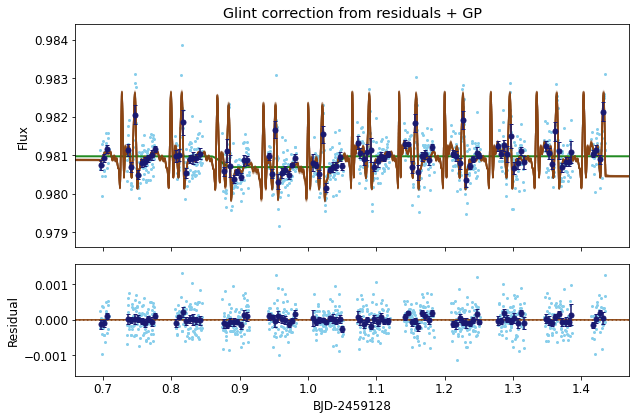

In [21]:
fig = dataset.plot_emcee(title='Glint correction from residuals + GP',
                         figsize=(9,6),fontsize=12, binwidth=0.005)

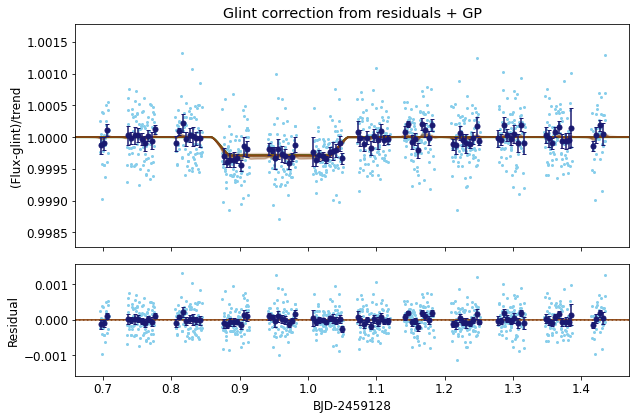

In [22]:
fig = dataset.plot_emcee(title='Glint correction from residuals + GP', detrend=True,
                         figsize=(9,6),fontsize=12, binwidth=0.005,)

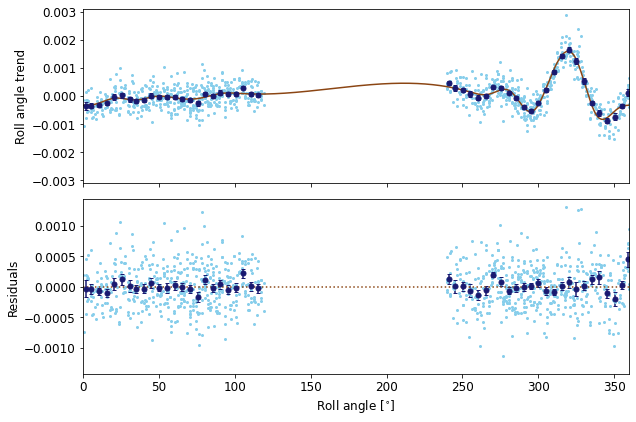

In [23]:
fig = dataset.rollangle_plot(figsize=(9,6),fontsize=12,binwidth=5)

&copy; Pierre Maxted, Keele University 2020